# Train Plots Notebook

This notebook shows the convergance for different method through loss-plots.

First, some global imports:

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../modules')

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn

## Non-Distributed Training

In this section we will train a reference model without distribution to get theoretical results.

Since we are using the MSE loss, it is defined as:

$$
    \frac{1}{N}\|y - (X\cdot w + b)\|^2_2
$$

With $N$ the number of samples, $y\in\mathbb{R}^N$ the targets, $X\in\mathbb{R}^{N\times 2}$ the design matrix, $w\in\mathbb{R}^{2\times 1}$ the weights, and $b\in\mathbb{R}$ the bias.

We have that the Lipschitz constant is:

$$
    L = \frac{2}{N} \|(X')^T\cdot X'\|
$$

Where $X'$ is the column concatenation of $X$ and the ones vector, and $\|\cdot\|$ is the spectral norm.

First, we will load the data and calculate $L$:

In [6]:
from data import get_data

num_samples = 2000


X, y = get_data(num_samples)
N = X.shape[0]

X_ = np.c_[X, np.ones((N, 1))]

w_opt = np.linalg.inv(X_.T@X_)@X_.T@y.numpy() #compute global optimum with normal equations. For strongly convex problems we have a unique minimum. 
diff = (X_@w_opt - y.numpy())
global_opt = (diff*diff).mean()

# same as || X^T X ||
s = np.linalg.svd(X_, compute_uv=False)[0]**2
L = 2/N * s

print('L :', L)
print('f(x*) : ', global_opt)

L : 3.5575142116705325
f(x*) :  0.05307472882123199


Now, we create the Least Squares model and train it,

In [25]:
from graph import model_lr

# best learning rate for GD
lr = 1 / L
print('lr :', lr)

# no. of independent runs
runs = 10
# epochs per run
epochs = 100

losses = np.empty((runs, epochs))

for i in range(runs):
    # set randomness
    np.random.seed(i)
    torch.manual_seed(i)

    model = model_lr(input_dim=X.shape[1], output_dim=y.shape[1])

    opt = torch.optim.SGD(model.parameters(), lr=lr)
    criteria = nn.MSELoss()

    for j in range(epochs):
        out = model(X)
        l = criteria(out, y)
        losses[i, j] = l.item()
        l.backward()

        opt.step()
        opt.zero_grad()

        if j % 20 == 0:
            print('run :', i, 'i :', j, 'train loss :', losses[i, j])
            
m_gl_losses = losses.mean(axis=0)
s_gl_losses = losses.std(axis=0)

lr : 0.28109515254203904
run : 0 i : 0 train loss : 0.3536953628063202
run : 0 i : 20 train loss : 0.05554120987653732
run : 0 i : 40 train loss : 0.053099069744348526
run : 0 i : 60 train loss : 0.05307496711611748
run : 0 i : 80 train loss : 0.053074728697538376
run : 1 i : 0 train loss : 0.40635934472084045
run : 1 i : 20 train loss : 0.05327809974551201
run : 1 i : 40 train loss : 0.05307673290371895
run : 1 i : 60 train loss : 0.05307474359869957
run : 1 i : 80 train loss : 0.053074728697538376
run : 2 i : 0 train loss : 0.0860448032617569
run : 2 i : 20 train loss : 0.05315040796995163
run : 2 i : 40 train loss : 0.05307547748088837
run : 2 i : 60 train loss : 0.05307473614811897
run : 2 i : 80 train loss : 0.053074728697538376
run : 3 i : 0 train loss : 1.2234253883361816
run : 3 i : 20 train loss : 0.05322403833270073
run : 3 i : 40 train loss : 0.05307620391249657
run : 3 i : 60 train loss : 0.05307473614811897
run : 3 i : 80 train loss : 0.053074728697538376
run : 4 i : 0 tra

## Plots

After obtaining losses for the non-distributed case, we read the CSV containing all the train info:

In [36]:
from pathlib import Path
dfs = []
for i, filename in enumerate(Path('.').glob('out*.csv')):
    df = pd.read_csv(filename)
    dfs += [df]
dfs = pd.concat(dfs, axis=0)
dfs['ind'] = dfs.index
dfs.set_index('ind')
m_dfs = dfs.groupby(['ind', 'topo']).mean()
s_dfs = dfs.groupby(['ind', 'topo']).std()
dfs = m_dfs
dfs['loss_std'] = s_dfs['loss']
dfs

,,nodes,lr,batch_size,mixing_steps,local_steps,loss,comms,loss_std
ind,topo,,,,,,,,
0,fc,1.0,0.281095,2000.0,1.0,1.0,0.125404,0.0,0.050211
1,fc,1.0,0.281095,2000.0,1.0,1.0,0.089594,0.0,0.038735
2,fc,1.0,0.281095,2000.0,1.0,1.0,0.077602,0.0,0.032447
3,fc,1.0,0.281095,2000.0,1.0,1.0,0.071591,0.0,0.026214
4,fc,1.0,0.281095,2000.0,1.0,1.0,0.067570,0.0,0.020912
...,...,...,...,...,...,...,...,...,...
1495,random,100.0,0.281095,2000.0,1.0,1.0,0.054324,2826547.2,0.000274
1496,random,100.0,0.281095,2000.0,1.0,1.0,0.054324,2855990.4,0.000274
1497,random,100.0,0.281095,2000.0,1.0,1.0,0.054324,2885433.6,0.000274


The plots can get quite cluttered.

Specify here which topologies not to show (leave as `[]` to show all topologies):

In [51]:
exclude_topos = ["ring"]

Now we can plot the train losses for the different topologies,

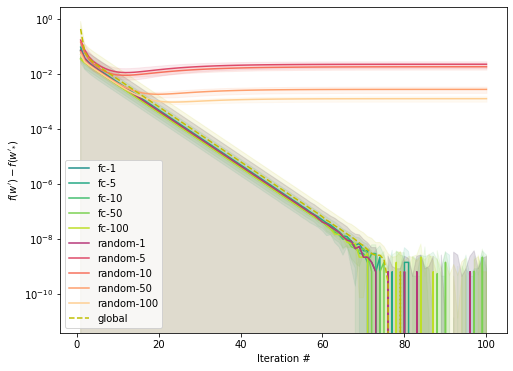

In [52]:
import itertools

# plot options
figsize = (8, 6)
alpha = 0.1

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
# ax.set_xscale('log')
ax.set_yscale('log')
cmaps = itertools.cycle(['viridis', 'magma', 'cool'])
for topo, d1 in dfs.groupby('topo'):
    if topo in exclude_topos:
        continue

    cmap = plt.get_cmap(next(cmaps))
    M = len([_ for _ in d1.groupby('nodes')])

    ind = 0
    for nb_nodes, d2 in d1.groupby('nodes'):
#         if nb_nodes == 10:
#             continue

        xaxis = range(1, len(d2['loss'])+1)

        color = cmap(ind*0.5/M + 0.5)
        ind += 1

        ax.plot(xaxis, d2['loss']-global_opt, label=f'{topo}-{int(nb_nodes)}', color=color)
        ax.fill_between(xaxis,
                        d2['loss']-global_opt-d2['loss_std'],
                        d2['loss']-global_opt+d2['loss_std'],
                        alpha=alpha, color=color)

p = ax.plot(xaxis, m_gl_losses[:len(xaxis)]-global_opt, 'y--', label='global')
color = p[0].get_color()
ax.fill_between(xaxis,
                m_gl_losses[:len(xaxis)]-global_opt-s_gl_losses[:len(xaxis)],
                m_gl_losses[:len(xaxis)]-global_opt+s_gl_losses[:len(xaxis)],
                alpha=alpha, color=color)

ax.legend()
ax.set_xlabel('Iteration #')
ax.set_ylabel(r"$f(w')-f(w'_{*})$")
# plt.ylim(0.05, None)
plt.show()

### Complexity per iteration

Here, we show the bytes required to achieve a certain threshold of the loss due to communication between nodes.

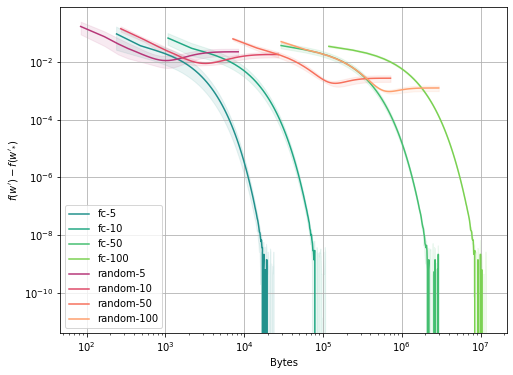

In [53]:
import itertools

# plot options
figsize = (8, 6)
alpha = 0.1

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
ax.set_xscale('log')
ax.set_yscale('log')
cmaps = itertools.cycle(['viridis', 'magma', 'cool'])
for topo, d1 in dfs.groupby('topo'):
    if topo in exclude_topos:
        continue

    cmap = plt.get_cmap(next(cmaps))
    M = len([_ for _ in d1.groupby('nodes')])

    ind = 0
    for nb_nodes, d2 in d1.groupby('nodes'):
        if nb_nodes <= 1:
            continue

        xaxis = d2['comms']

        color = cmap(ind*0.5/M + 0.5)
        ind += 1

        ax.plot(xaxis, d2['loss']-global_opt, label=f'{topo}-{int(nb_nodes)}', color=color)
        ax.fill_between(xaxis,
                        d2['loss']-global_opt-d2['loss_std'],
                        d2['loss']-global_opt+d2['loss_std'],
                        alpha=alpha, color=color)

ax.legend()
ax.set_xlabel('Bytes')
ax.set_ylabel(r"$f(w')-f(w'_{*})$")
ax.grid()
# plt.ylim(0.05, None)
plt.show()